Before running the spot detection notebook, run the first notebook, "Read_files_create_batch.ipynb'.

In this notebook we will detect the fish spots using an automatic method called UFISH and a semi manual one
called BIGFISH.

23/05/25     Jacques Bourg @ Florian Muller lab. Institut Pasteur.

<img src="./HOX_pipeline.png" alt="LNP pipeline" width="1200" height="477">

In [13]:
import os
import sys
import numpy as np
from pathlib import Path
import skimage.io as io
import napari

import ipywidgets as widgets
from IPython.display import display

In [14]:
%load_ext autoreload
%autoreload 2

base_dir = Path("../../src").resolve()
sys.path.append(str(base_dir))
sys.path.append(str(base_dir / "utils"))
sys.path.append(str(base_dir / "detection_fish"))
sys.path.append(str(base_dir / "segmentation"))

from utils.parameters_tracking import Parameter_tracking as Track
from utils.file_handling import FileProcessor
from detection_fish.detect_fish_spots import DetectionPipeline
from detection_fish.thresh_big_fish_napariV3 import SpotsThresholding 
from segmentation.refine_seg import Segmentation

tk  = Track()
det = DetectionPipeline()
sg  = Segmentation()
fp  = FileProcessor()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
var = str(Path('../Analysis'))
batch_folders = os.listdir(var)
dropdown = widgets.Dropdown(options=batch_folders, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('2024-11-18_Helena-Ho…

In [16]:
n         = np.where(np.array(batch_folders) == dropdown.value)[0][0]
file_path = str(Path(var) / Path(batch_folders[n]) / Path(batch_folders[n] +'.json'))
constants = tk.load_json(file_path)
batch_name= constants['BATCH_NAME']; print(batch_name)

2024-11-18_Helena-Hox-9-10_spinning_2


In [17]:
modalities = constants['MODALITIES']
dropdown2 = widgets.Dropdown(options=modalities, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown2)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('EXPERIMENT', 'CONTRO…

In [18]:
n2       = np.where(np.array(modalities) == dropdown2.value)[0][0]
modality = modalities[n2]; print(modality)

EXPERIMENT


In [19]:
channel_cell = constants['CHANNELS'] # (Doesn't make sense to select DAPI)
dropdown3    = widgets.Dropdown(options=channel_cell, description='Select:', layout=widgets.Layout(width='auto', min_width='150px')); display(dropdown3)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('DAPI', 'HOXC8', 'HOX…

In [32]:
n3     = np.where(np.array(channel_cell) == dropdown3.value)[0][0]
chan_c = channel_cell[n3]; print(chan_c)

HOXA10


In [33]:
batch_fish = constants[f'BATCH_{modality}_{chan_c}']; print(batch_fish);

['../Acquisition/2024-11-18_Helena-Hox-9-10_spinning_2/EXPERIMENT/HOXA10/HM40-J3DIFF-NT6h-HOXA10-620_HOXC8-520-1002-1_HOXA10.tif', '../Acquisition/2024-11-18_Helena-Hox-9-10_spinning_2/EXPERIMENT/HOXA10/HM40-J3DIFF-NT24h-HOXA10-620_HOXC8-520-1005-1_HOXA10.tif', '../Acquisition/2024-11-18_Helena-Hox-9-10_spinning_2/EXPERIMENT/HOXA10/HM40-J3DIFF-NT48h-HOXA10-620_HOXC8-520-1008-1_HOXA10.tif', '../Acquisition/2024-11-18_Helena-Hox-9-10_spinning_2/EXPERIMENT/HOXA10/HM40-J3DIFF-GDF6h-HOXA10-620_HOXC8-522-1_HOXA10.tif', '../Acquisition/2024-11-18_Helena-Hox-9-10_spinning_2/EXPERIMENT/HOXA10/HM40-J3DIFF-GDF24h-HOXA10-620_HOXC8-525-1_HOXA10.tif', '../Acquisition/2024-11-18_Helena-Hox-9-10_spinning_2/EXPERIMENT/HOXA10/HM40-J3DIFF-GDF48h-HOXA10-620_HOXC8-528-1_HOXA10.tif', '../Acquisition/2024-11-18_Helena-Hox-9-10_spinning_2/EXPERIMENT/HOXA10/HM40-J3DIFF-FGFGDF6h-HOXA10-620_HOXC8-531-1_HOXA10.tif', '../Acquisition/2024-11-18_Helena-Hox-9-10_spinning_2/EXPERIMENT/HOXA10/HM40-J3DIFF-FGFGDF24h-HOXA

In [34]:
spots_folder = Path(f'../Analysis/{batch_name}/{modality}/{chan_c}/spots')
if not spots_folder.exists():
    spots_folder.mkdir(parents=True)
print(spots_folder)

spots_ufish_folder = Path(f'../Analysis/{batch_name}/{modality}/{chan_c}/spots/UFISH')
if not spots_ufish_folder.exists():
    spots_ufish_folder.mkdir(parents=True)
print(spots_ufish_folder)

spots_bigfish_folder = Path(f'../Analysis/{batch_name}/{modality}/{chan_c}/spots/BIGFISH')
if not spots_bigfish_folder.exists():
    spots_bigfish_folder.mkdir(parents=True)
print(spots_bigfish_folder)

../Analysis/2024-11-18_Helena-Hox-9-10_spinning_2/EXPERIMENT/HOXA10/spots
../Analysis/2024-11-18_Helena-Hox-9-10_spinning_2/EXPERIMENT/HOXA10/spots/UFISH
../Analysis/2024-11-18_Helena-Hox-9-10_spinning_2/EXPERIMENT/HOXA10/spots/BIGFISH


In [35]:
#a) UFISH (without deconvolution)

base_dir        = str(Path().resolve().parent.parent)
dots_ufish_path = spots_ufish_folder / f"dots_{modality}_{chan_c}_UFISH.npy"
viewer4         = napari.Viewer(title="UFISH on raw data")
dict_ufish_dots = {}
dict_ufish_dots_local_copy = {}  # this dict contains the same information but the keys are different

counter = 0
for ind_l, file in enumerate(batch_fish):
    file            = Path(file)
    file_abs_path   = str(Path(batch_fish[ind_l]).resolve())
    im_rna          = io.imread(batch_fish[ind_l])
    target_dir      = str(Path().resolve().parent / Path(f'Analysis/{batch_name}/detected_ufish.npy'))
    spots_uf_raw    = det.spot_ufish(file_abs_path, target_dir, base_dir)
    
    if im_rna.ndim == 3:
        mip_im_rna = np.max(im_rna, axis=0)    
    elif im_rna.ndim == 2:
        mip_im_rna = im_rna
    
    if np.shape(spots_uf_raw)[1] == 3:
        spots_uf_raw_2d = spots_uf_raw[:,1:]
    elif np.shape(spots_uf_raw)[1] == 2:    
        spots_uf_raw_2d = spots_uf_raw
    
    val = np.percentile(mip_im_rna, 99)    
    viewer4.add_image(mip_im_rna, contrast_limits=(0, val), rgb=False, name=f"{modality} {file.stem}", opacity=0.8)
    viewer4.add_points(spots_uf_raw_2d, name=f"Spots {modality} {file.stem}", size=4,  border_color='#FF0000', face_color=[0, 0, 0, 0]);

    if counter != 0:
        viewer4.layers[f"{modality} {file.stem}"].visible       = False
        viewer4.layers[f"Spots {modality} {file.stem}"].visible = False 

    base_name = '_'.join(file.stem.split('_')[:-1])
    dict_ufish_dots[base_name] = spots_uf_raw
    dict_ufish_dots_local_copy[file.stem] = spots_uf_raw
    counter += 1

format_spots = 'spots_IDzyx'
fp.save_spots_distributed_files(dots_ufish_path, format_spots, dict_ufish_dots, im_rna.ndim)

CompletedProcess(args=['bash', '/home/jacques/Documents/FISH/Data_analysis/pipeline_smfish_in_apifish/src/detection_fish/env_activate_ufish_v2.sh', '/home/jacques/Documents/FISH/Data_analysis/pipeline_smfish_in_apifish/HOX_pipeline/Acquisition/2024-11-18_Helena-Hox-9-10_spinning_2/EXPERIMENT/HOXA10/HM40-J3DIFF-NT6h-HOXA10-620_HOXC8-520-1002-1_HOXA10.tif', '/home/jacques/Documents/FISH/Data_analysis/pipeline_smfish_in_apifish/HOX_pipeline/Analysis/2024-11-18_Helena-Hox-9-10_spinning_2/detected_ufish.npy', '/home/jacques/Documents/FISH/Data_analysis/pipeline_smfish_in_apifish'], returncode=0, stdout='Python result: \n', stderr="2025-06-04 09:32:59.380 | INFO     | ufish.api:init_model:70 - Initializing ufish model with kwargs: {}\n2025-06-04 09:32:59.380 | INFO     | ufish.api:init_model:72 - Number of parameters: 162959\n2025-06-04 09:32:59.539 | INFO     | ufish.api:init_model:78 - CUDA is available, using GPU.\n2025-06-04 09:32:59.539 | INFO     | ufish.api:_load_pth_file:232 - Loadin

Adjust the threshold by eye. Often there is some kind of inflexion point in the counts vs threshold curve at which the noise distribution and the signal distribution overlap.
When one doesn't see this point look for a point in the noisy regime (left) which the derivative decreases in absolute value.  

In [36]:
format_spots        = 'spots_IDzyx'
dot_ufish_path      = spots_ufish_folder / f"dots_{modality}_{chan_c}_UFISH.npy"
dict_ufish_dots     = fp.load_spots_distributed_files(dot_ufish_path, format=format_spots)

voxel_size_nm       = (108, 108)   # (z,y,x) or (y,x)  this parameter is important, you can check it's value opening the original files in fiji (Image/show info), or in the microscope metadata
object_radius_nm    = (432, 432)   # estimate this parameter by eye: number of pixels of spots diameter times the voxels size (respective Z, Y and X dimension)

batch_path          = [Path(el) for el in batch_fish]
dots_bigfish_path   = spots_bigfish_folder / f"dots_{modality}_{chan_c}_BIGFISH.npy"
thresh_bigfish_path = spots_bigfish_folder / f"thresh_{modality}_{chan_c}_BIGFISH.npy"

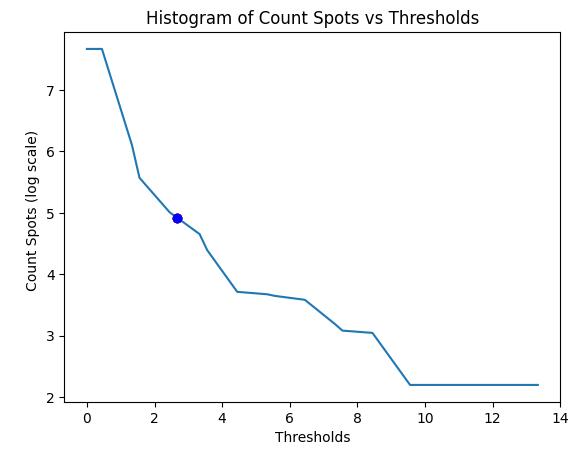

/home/jacques/miniconda3/envs/base_env_apifish/lib/python3.9/site-packages/apifish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)
/home/jacques/miniconda3/envs/base_env_apifish/lib/python3.9/site-packages/apifish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


In [ ]:
sth0 = SpotsThresholding(BATCH = batch_path, BATCH_NAME= batch_name, voxel_size_nm=voxel_size_nm, 
                         object_radius_nm=object_radius_nm, spots_other_method=dict_ufish_dots_local_copy, subtract_fish=False)
sth0.run()

After closing the app, pursue here.

In [38]:
# rename the keys in order to have as key only the base name
dict_dots = {}
for key, value in sth0.detected_spots.items():
    dict_dots['_'.join(key.split('_')[:-1])] = value

In [39]:
fp.save_spots_distributed_files(dots_bigfish_path, format_spots, dict_dots, im_rna.ndim)
np.save(thresh_bigfish_path, sth0.dict_thresh_spot)

In [40]:
exec(f"DOTS_UFISH_{modality}_{chan_c}_PATH   = dots_ufish_path", globals())
exec(f"DOTS_BIGFISH_{modality}_{chan_c}_PATH = dots_bigfish_path", globals())
exec(f"THRESH_BIGFISH_{modality}_{chan_c}_PATH = thresh_bigfish_path", globals())
exec(f"SPOTS_FOLDER_{modality}_{chan_c}_PATH = spots_folder")
exec(f"SPOTS_FORMAT = format_spots")

exec(f"VOXEL_SIZE_NM_BF_{modality}_{chan_c}_Z = voxel_size_nm[0]", globals())
exec(f"VOXEL_SIZE_NM_BF_{modality}_{chan_c}_YX = voxel_size_nm[1]", globals())
exec(f"OBJECT_RADIUS_NM_BF{modality}_{chan_c}_Z = object_radius_nm[0]", globals())
exec(f"OBJECT_RADIUS_NM_BF{modality}_{chan_c}_YX = object_radius_nm[1]", globals())

In [41]:
constants2 = tk.collect_constants()
tk.save_constants_and_commit_hash(constants2, batch_name, folder_path = Path(f"../Analysis/{batch_name}"))